In [193]:
import pandas as pd
import numpy as np
import os
import math
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import pearsonr, spearmanr
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

df = pd.read_excel("initial_data/nipt_data.xlsx")
print(df.head())

   序号  孕妇代码  年龄     身高    体重                 末次月经 IVF妊娠      检测日期  检测抽血次数  \
0   1  A001  31  160.0  72.0  2023-02-01 00:00:00  自然受孕  20230429       1   
1   2  A001  31  160.0  73.0  2023-02-01 00:00:00  自然受孕  20230531       2   
2   3  A001  31  160.0  73.0  2023-02-01 00:00:00  自然受孕  20230625       3   
3   4  A001  31  160.0  74.0  2023-02-01 00:00:00  自然受孕  20230716       4   
4   5  A002  32  149.0  74.0  2023-11-09 00:00:00  自然受孕  20240219       1   

    检测孕周  ...    Y染色体浓度    X染色体浓度  13号染色体的GC含量  18号染色体的GC含量  21号染色体的GC含量  \
0  11w+6  ...  0.025936  0.038061     0.377069     0.389803     0.399399   
1  15w+6  ...  0.034887  0.059572     0.371542     0.384771     0.391706   
2  20w+1  ...  0.066171  0.075995     0.377449     0.390582     0.399480   
3  22w+6  ...  0.061192  0.052305     0.375613     0.389251     0.397212   
4  13w+6  ...  0.059230  0.059708     0.380260     0.393618     0.404868   

   被过滤掉读段数的比例  染色体的非整倍体  怀孕次数  生产次数  胎儿是否健康  
0    0.027484       NaN     1     

In [194]:
df = df[df['Y染色体浓度'].notna()].copy()

def convert_ga_to_decimal(ga_str):
    """将“Xw+Y”格式转换为小数周（如11w+6 = 11 + 6/7 ≈ 11.86周）"""
    if pd.isna(ga_str):
        return np.nan
    # 拆分“周”和“天”部分，适配实际数据格式
    if 'w+' in str(ga_str):
        w_part, d_part = str(ga_str).split('w+')
    else:
        return np.nan  # 排除格式异常的孕周（如纯数字）
    try:
        return int(w_part) + int(d_part) / 7
    except (ValueError, IndexError):
        return np.nan

# 转换孕周并筛选10-25周样本
df['小数孕周'] = df['检测孕周'].apply(convert_ga_to_decimal)
df = df[(df['小数孕周'] >= 10) & (df['小数孕周'] <= 25)]

# 4. 测序质量筛选（C题.pdf附录1：GC含量正常范围40%~60%，对应真实列名“GC含量”（列16））
# 注意：数据中GC含量可能以小数形式呈现（如0.377069=37.7%），需先转换为百分比
df['GC含量_百分比'] = df['GC含量'] * 100
df = df[(df['GC含量_百分比'] >= 40) & (df['GC含量_百分比'] <= 60)]

# 5. 剔除Y染色体浓度异常值（C题.pdf4：男胎Y浓度达标值≥4%，数据中为小数（如0.025936=2.59%），合理范围0~15%）
df['Y染色体浓度_百分比'] = df['Y染色体浓度'] * 100
df = df[(df['Y染色体浓度_百分比'] >= 0) & (df['Y染色体浓度_百分比'] <= 15)]

# 6. 输出筛选结果（验证数据有效性）
print("=== 数据筛选结果 ===")
print(f"原始数据总样本数：{len(df)}")
print(f"男胎样本数（Y染色体浓度非空）：{len(df[df['Y染色体浓度'].notna()])}")
print(f"10-25周+正常GC的有效男胎样本数：{len(df)}")

# 7. 查看核心变量描述统计（贴合C题.pdf问题1的分析对象）
print("\n=== 核心变量描述统计（有效样本） ===")
core_vars = df[['Y染色体浓度_百分比', '小数孕周', '孕妇BMI']].rename(columns={
    'Y染色体浓度_百分比': 'Y染色体浓度(%)',
    '小数孕周': '孕周（小数）',
    '孕妇BMI': 'BMI'
})
print(core_vars.describe())

# 标记同一孕妇的多次检测（C题.pdf6：存在多次采血检测，对应真实列名“孕妇代码”（列2））
df['检测次数'] = df.groupby('孕妇代码')['检测日期'].cumcount() + 1  # 按检测日期排序标记次数

# 查看重复检测示例（以孕妇A001为例，匹配你提供的前3行数据）
print("\n=== 同一孕妇多次检测示例（孕妇A001） ===")
a001_data = df[df['孕妇代码'] == 'A001'][
    ['孕妇代码', '检测次数', '检测孕周', '小数孕周', 'Y染色体浓度_百分比', '孕妇BMI']
].sort_values('检测次数')

print(a001_data)

=== 数据筛选结果 ===
原始数据总样本数：519
男胎样本数（Y染色体浓度非空）：519
10-25周+正常GC的有效男胎样本数：519

=== 核心变量描述统计（有效样本） ===
        Y染色体浓度(%)      孕周（小数）         BMI
count  519.000000  519.000000  519.000000
mean     7.574064   16.120286   32.304640
std      2.916116    3.642887    2.747084
min      1.000389   11.000000   26.619343
25%      5.219353   13.142857   30.370302
50%      7.630164   15.571429   32.017138
75%      9.839118   17.857143   33.920238
max     14.825457   24.857143   46.875000

=== 同一孕妇多次检测示例（孕妇A001） ===
Empty DataFrame
Columns: [孕妇代码, 检测次数, 检测孕周, 小数孕周, Y染色体浓度_百分比, 孕妇BMI]
Index: []


In [195]:
BMI_info=df['孕妇BMI']
gestational_weeks_info=df['小数孕周']

In [196]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

#拟合模型
model = smf.mixedlm(
    "Y染色体浓度 ~ 孕妇BMI + 小数孕周",
    df,
    groups=df["孕妇代码"]
)
result1 = model.fit()

# 打印结果汇总
print(result1.summary())

#算R²
actual = df["Y染色体浓度"]
predictions = result1.fittedvalues
r_squared1 = r2_score(actual, predictions)
print("Marginal R²:", r_squared1)
mse = mean_squared_error(actual, predictions)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

random_effects_variance = result1.cov_re
print("随机效应方差（组间方差）:")
print(random_effects_variance)

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Y染色体浓度   
No. Observations: 519     Method:             REML     
No. Groups:       231     Scale:              0.0002   
Min. group size:  1       Log-Likelihood:     1213.4226
Max. group size:  6       Converged:          Yes      
Mean group size:  2.2                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.072    0.019  3.739 0.000  0.034  0.110
孕妇BMI        -0.001    0.001 -1.730 0.084 -0.002  0.000
小数孕周          0.002    0.000  9.688 0.000  0.002  0.003
Group Var     0.001    0.007                           

Marginal R²: 0.8525497725290626
RMSE: 0.011186874225398538
随机效应方差（组间方差）:
          Group
Group  0.000675


c:\Users\xia\anaconda3\envs\byd\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [197]:
model = smf.mixedlm(
    formula="Y染色体浓度 ~ 孕妇BMI * 小数孕周",
    data=df,
    groups=df["孕妇代码"]
)
result2 = model.fit()
print(result2.summary())

#算R²
actual = df["Y染色体浓度"]
predictions = result2.fittedvalues
r_squared2 = r2_score(actual, predictions)
print("Marginal R²:", r_squared2)
mse = mean_squared_error(actual, predictions)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Y染色体浓度   
No. Observations: 519     Method:             REML     
No. Groups:       231     Scale:              0.0002   
Min. group size:  1       Log-Likelihood:     1207.5348
Max. group size:  6       Converged:          Yes      
Mean group size:  2.2                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.172    0.047  3.633 0.000  0.079  0.265
孕妇BMI        -0.004    0.001 -2.822 0.005 -0.007 -0.001
小数孕周         -0.004    0.003 -1.374 0.169 -0.009  0.001
孕妇BMI:小数孕周    0.000    0.000  2.309 0.021  0.000  0.000
Group Var     0.001    0.007                           

Marginal R²: 0.8554486508860286
RMSE: 0.011076361121118344


c:\Users\xia\anaconda3\envs\byd\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [199]:
model = smf.mixedlm(
    "Y染色体浓度 ~ 孕妇BMI * 小数孕周",  # 固定效应：交互项
    df,
    groups=df["孕妇代码"],                # 按孕妇代码分组（随机截距）
    re_formula="1 + 孕妇BMI + 小数孕周"  # 随机截距和随机斜率
)

result4 = model.fit()
print(result4.summary())

#算R²
actual = df["Y染色体浓度"]
predictions = result4.fittedvalues
r_squared4 = r2_score(actual, predictions)
print("Marginal R²:", r_squared4)
mse = mean_squared_error(actual, predictions)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

c:\Users\xia\anaconda3\envs\byd\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\xia\anaconda3\envs\byd\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\xia\anaconda3\envs\byd\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  Y染色体浓度   
No. Observations:    519      Method:              REML     
No. Groups:          231      Scale:               0.0001   
Min. group size:     1        Log-Likelihood:      1252.5643
Max. group size:     6        Converged:           Yes      
Mean group size:     2.2                                    
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          0.160    0.060  2.684 0.007  0.043  0.276
孕妇BMI             -0.004    0.002 -2.255 0.024 -0.008 -0.001
小数孕周              -0.004    0.004 -1.129 0.259 -0.011  0.003
孕妇BMI:小数孕周         0.000    0.000  2.053 0.040  0.000  0.000
Group Var          0.000    0.533                           
Group x 孕妇BMI Cov  0.000    0.017                           
孕妇BMI Var          0.000    0.001   

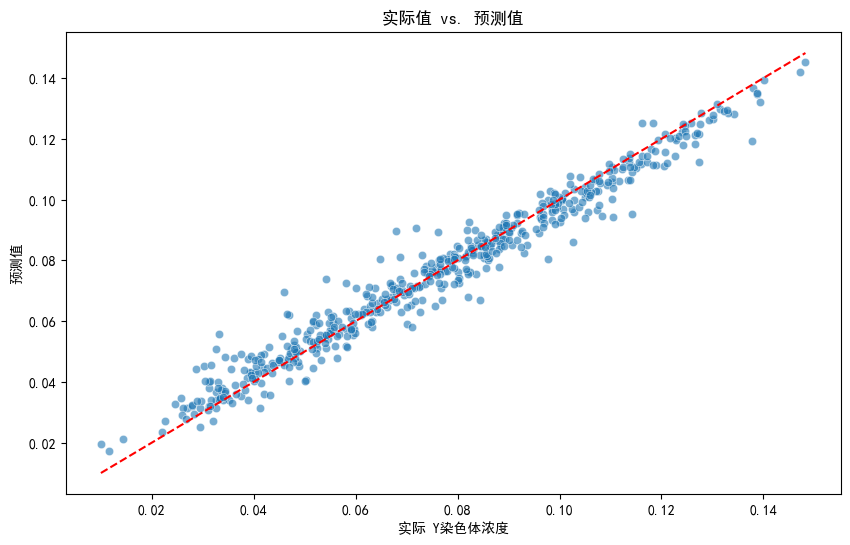

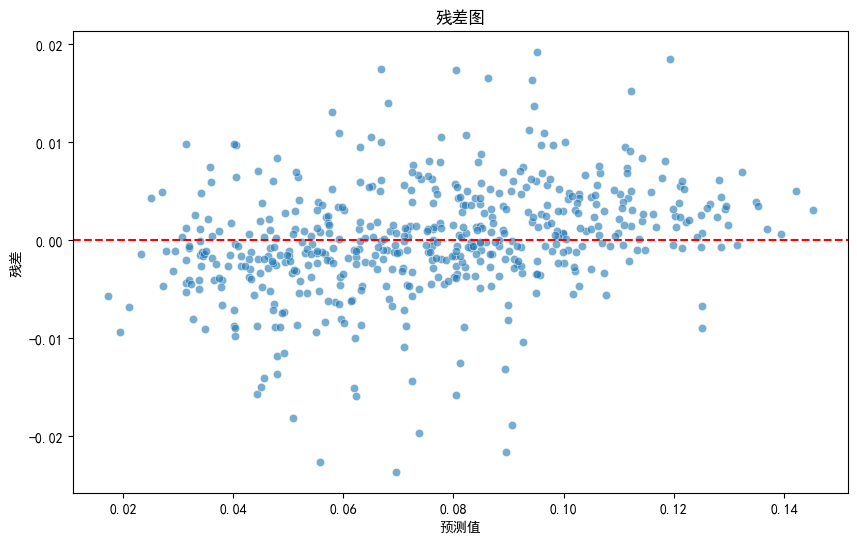

In [200]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df["预测值"] = result3.fittedvalues
df["残差"] = df["Y染色体浓度"] - df["预测值"]  # 残差 = 实际值 - 预测值

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Y染色体浓度", y="预测值", alpha=0.6)
plt.plot([df["Y染色体浓度"].min(), df["Y染色体浓度"].max()],
         [df["Y染色体浓度"].min(), df["Y染色体浓度"].max()],
         'r--')  # 45度对角线
plt.title("实际值 vs. 预测值")
plt.xlabel("实际 Y染色体浓度")
plt.ylabel("预测值")
plt.show()

# 可视化 2：残差图(图)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="预测值", y="残差", alpha=0.6)
plt.axhline(0, color='r', linestyle='--')  # 中心线
plt.title("残差图")
plt.xlabel("预测值")
plt.ylabel("残差")
plt.show()


In [ ]:
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd
from pygam import LinearGAM, s, te
from sklearn.metrics import r2_score, mean_squared_error

X1 = df["孕妇BMI"].values
X2 = df["小数孕周"].values
X = np.column_stack((X1, X2))
y = df["Y染色体浓度"].values
gam = LinearGAM(s(0) + s(1) + te(0, 1)).gridsearch(X, y)
gam.fit(X, y)

df["gam_fit"] = gam.predict(X)
df["residual"] = df["Y染色体浓度"] - df["gam_fit"]

# 混合效应模型，包含 X1 和 X2 的固定效应
mixed = smf.mixedlm(
    "residual ~ 孕妇BMI + 小数孕周",
    df,
    groups=df["孕妇代码"]
)

mixed_result = mixed.fit()
print(mixed_result.summary())

re = mixed_result.random_effects
df["random_effect"] = df["孕妇代码"].map(lambda g: re[g]["Group"])

df["final_pred"] = df["gam_fit"] + df["random_effect"]

actual = df["Y染色体浓度"]
pred = df["final_pred"]

r2 = r2_score(actual, pred)
mse = mean_squared_error(actual, pred)
rmse = np.sqrt(mse)

print("GAMM R²:", r2)
print(f"GAMM RMSE: {rmse}")


  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:02
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:02
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:01
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:01
 45% (5 of 11) |###########              | Elapsed Time: 0:00:01 ETA:   0:00:01
 54% (6 of 11) |#############            | Elapsed Time: 0:00:01 ETA:   0:00:01
 63% (7 of 11) |###############          | Elapsed Time: 0:00:01 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:01 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:02 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:02 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: residual 
No. Observations: 519     Method:             REML     
No. Groups:       231     Scale:              0.0002   
Min. group size:  1       Log-Likelihood:     1221.0607
Max. group size:  6       Converged:          Yes      
Mean group size:  2.2                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    -0.034    0.018 -1.870 0.061 -0.070  0.002
孕妇BMI         0.000    0.001  0.393 0.694 -0.001  0.001
小数孕周          0.002    0.000  6.716 0.000  0.001  0.002
Group Var     0.001    0.006                           

GAMM R²: 0.7946310841779057
GAMM RMSE: 0.013202415212431321


c:\Users\xia\anaconda3\envs\byd\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


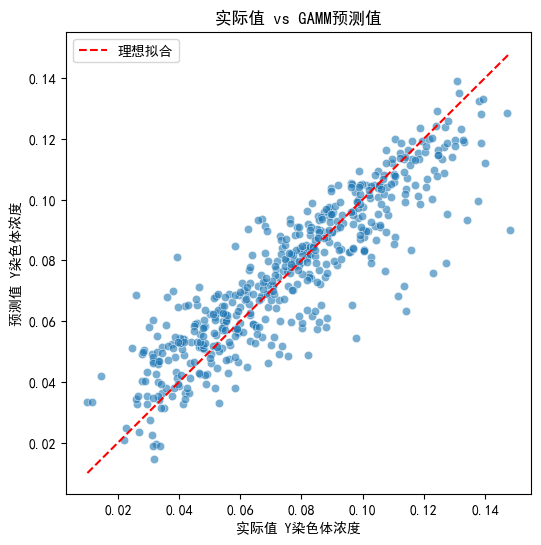

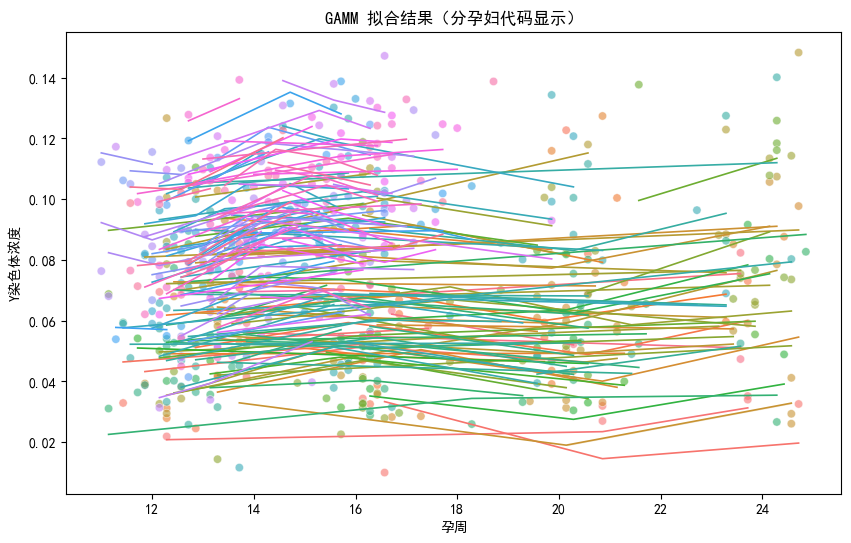

In [203]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=actual, y=pred, alpha=0.6)
plt.plot([actual.min(), actual.max()],
         [actual.min(), actual.max()],
         color='red', linestyle='--', label="理想拟合")
plt.xlabel("实际值 Y染色体浓度")
plt.ylabel("预测值 Y染色体浓度")
plt.title("实际值 vs GAMM预测值")
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
sns.scatterplot(x=df["小数孕周"], y=df["Y染色体浓度"], 
                hue=df["孕妇代码"], alpha=0.6, legend=False)

sns.lineplot(x=df["小数孕周"], y=df["final_pred"], 
             hue=df["孕妇代码"], lw=1.2, legend=False)

plt.xlabel("孕周")
plt.ylabel("Y染色体浓度")
plt.title("GAMM 拟合结果（分孕妇代码显示）")
plt.show()

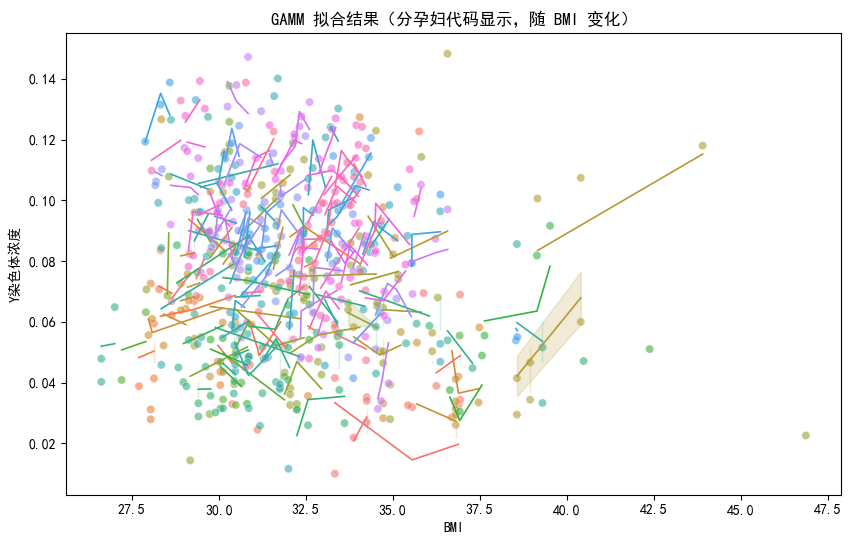

In [204]:
import matplotlib.pyplot as plt
import seaborn as sns
# 设置图形大小
plt.figure(figsize=(10, 6))
# 绘制实际值的散点图
sns.scatterplot(x=df["孕妇BMI"], y=df["Y染色体浓度"], 
                hue=df["孕妇代码"], alpha=0.6, legend=False)
# 绘制 GAMM 模拟的预测曲线
sns.lineplot(x=df["孕妇BMI"], y=df["final_pred"], 
             hue=df["孕妇代码"], lw=1.2, legend=False)
# 添加标签和标题
plt.xlabel("BMI")
plt.ylabel("Y染色体浓度")
plt.title("GAMM 拟合结果（分孕妇代码显示，随 BMI 变化）")
plt.show()